<a href="https://colab.research.google.com/github/siddhanthnagrath1/Prasunet_ML_02/blob/main/Prasunet_ML_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.spatial import ConvexHull

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib
import pickle

In [2]:
data = pd.read_csv('Mall_Customers (1).csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
int(data.duplicated().sum())

0

In [5]:
data.dtypes.value_counts()

int64     4
object    1
Name: count, dtype: int64

In [6]:
try:
    data.insert(loc = len(data.columns), column = 'Spending Score', value = data['Spending Score (1-100)'])
    data.insert(loc = len(data.columns)-2, column = 'Annual Income', value = data['Annual Income (k$)'])
    data = data.drop(columns=['Annual Income (k$)', 'Spending Score (1-100)'])
except: pass
data.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


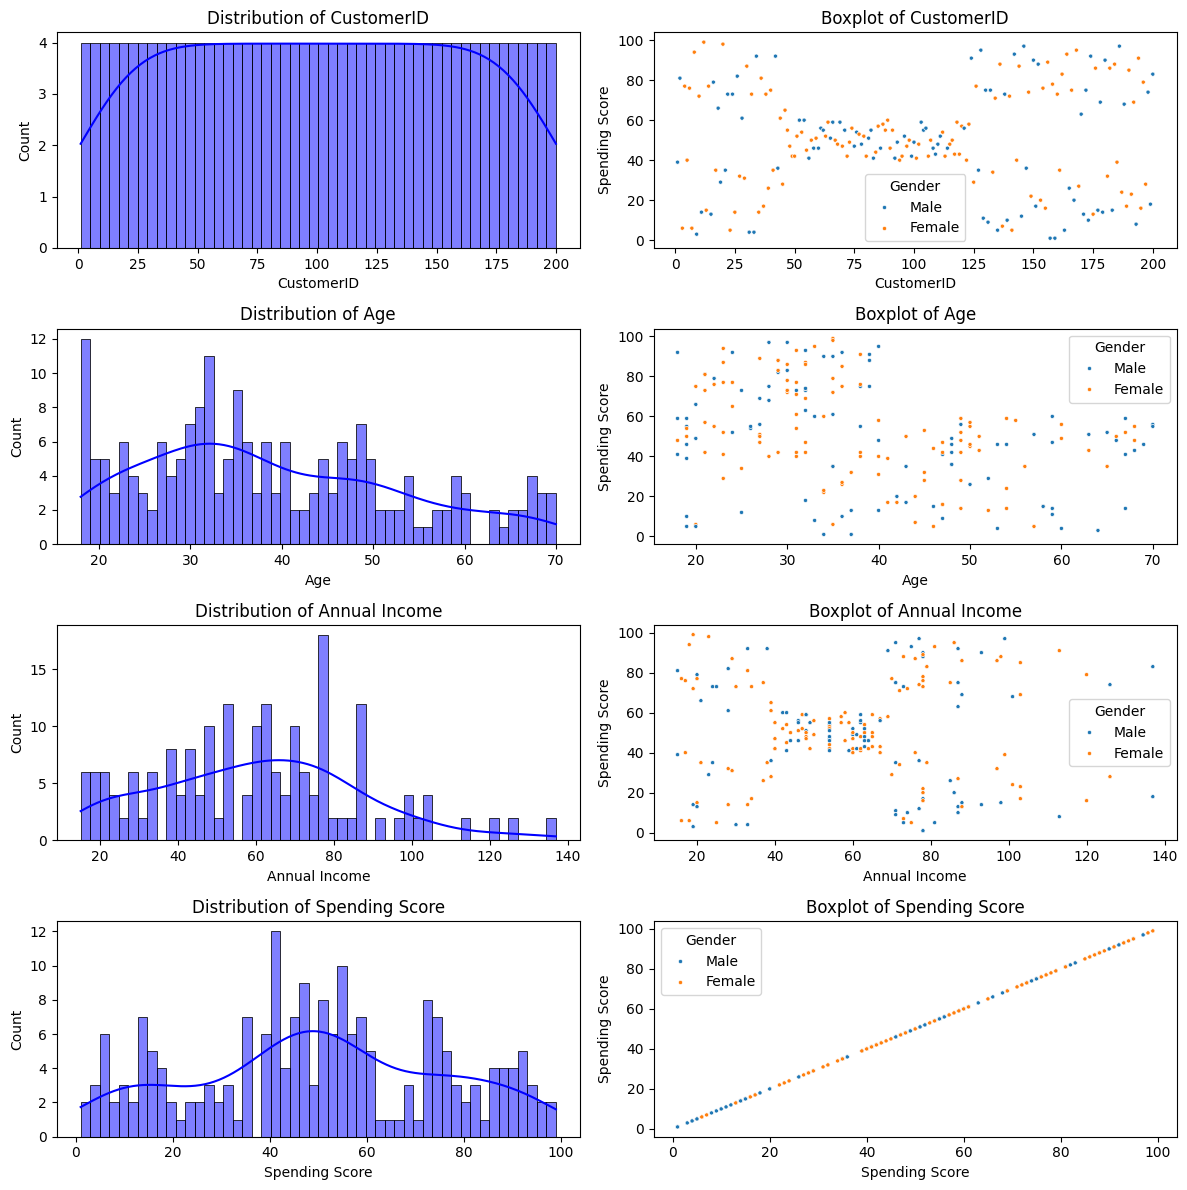

In [7]:
cols = list(data.dtypes[data.dtypes == 'int64'].index)

fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(12, len(cols) * 3))

for index, col in enumerate(cols):
    sns.histplot(data=data, x=col, bins=50, kde=True, ax=ax[index, 0], color='blue')
    sns.scatterplot(data = data,x=data[col], y=data['Spending Score'], ax=ax[index, 1], color = 'blue', hue='Gender', hue_order=['Male', 'Female'], marker = '.')

    ax[index, 0].set_title(f'Distribution of {col}')
    ax[index, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

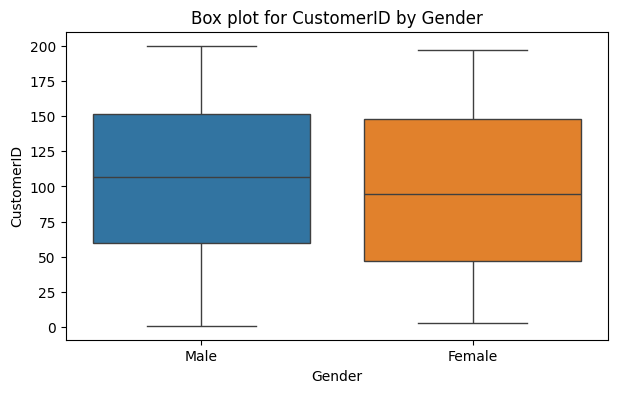

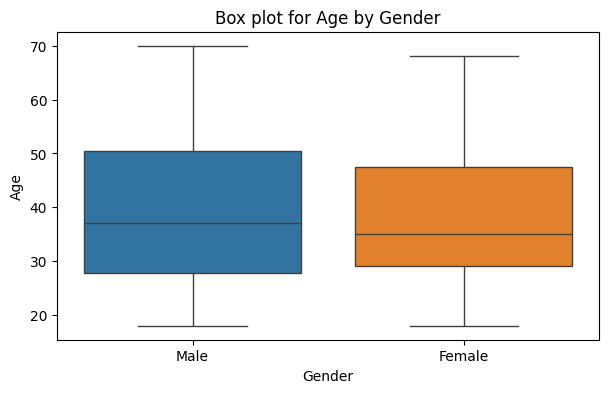

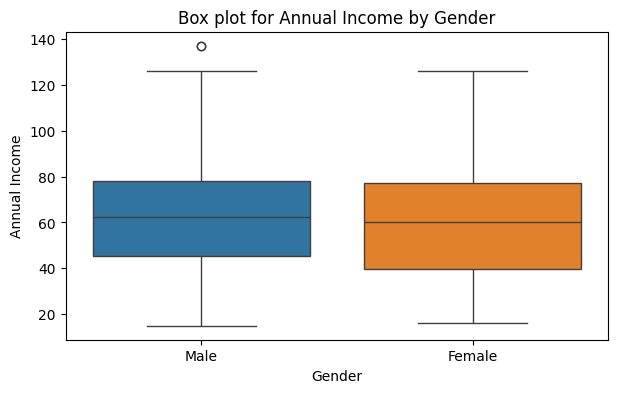

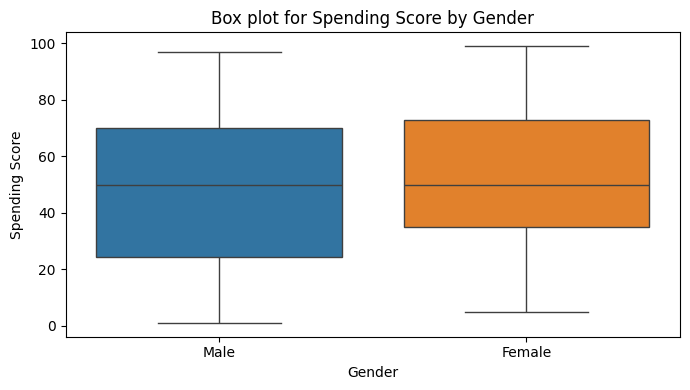

In [8]:
for column in cols:
    if(column == 'Gender'): continue
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=data, x='Gender', y=column, hue='Gender' )
    plt.title(f'Box plot for {column} by Gender')

plt.tight_layout()
plt.show()

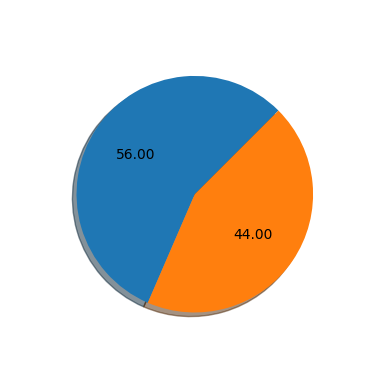

In [9]:
plt.pie(x = data['Gender'].value_counts(), autopct = '%.2f',startangle=45, normalize=True, shadow = True, radius = 0.8)
plt.show()

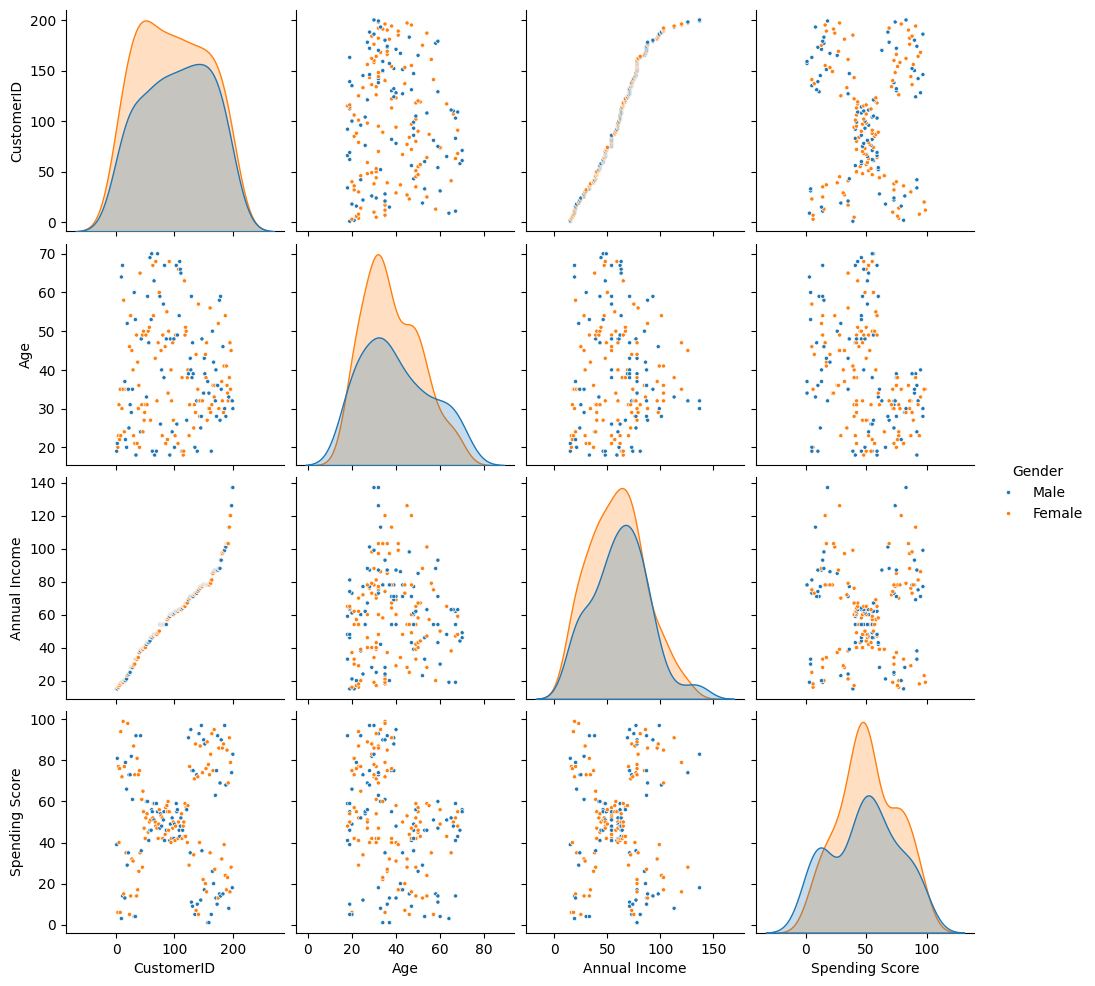

In [10]:
sns.pairplot(data = data, hue = 'Gender', hue_order=['Male', 'Female'], markers = '.')

plt.show()

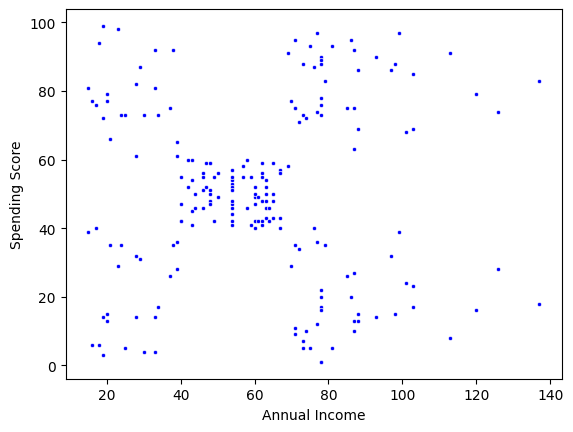

In [11]:
sns.scatterplot(x = data['Annual Income'], y = data['Spending Score'], marker = '.', color = 'blue')
plt.show()

In [12]:
fdata = data.loc[:, ['Annual Income', 'Spending Score']]
fdata.head()

,Annual Income,Spending Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


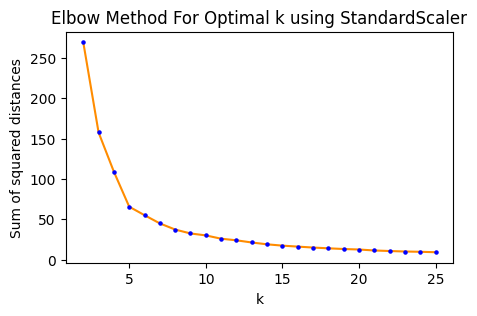

scaler used StandardScaler() 
n_clusters = 25 
elbow_score 9.106819428907624


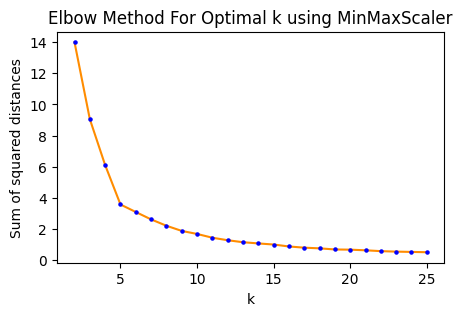

scaler used MinMaxScaler() 
n_clusters = 25 
elbow_score 0.5202388584297448


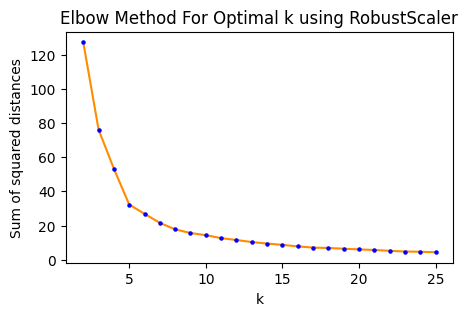

scaler used RobustScaler() 
n_clusters = 25 
elbow_score 4.410882426386619


In [13]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
model = KMeans()

for scaler in scalers:
    sosd = dict()
    data_scaled = scaler.fit_transform(fdata)
    K = range(2, 26)
    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        km = km.fit(data_scaled)
        sosd[k] = (km.inertia_)

    sorted_sosd = {key: value for key, value in sorted(sosd.items(), key=lambda item: item[1])}

    plt.figure(figsize=(5, 3))

    plt.scatter(K, sosd.values(), color='blue', s = 20, marker = '.', zorder = 5)
    sns.lineplot(x=K, y=sosd.values(), color='darkorange')

    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title(f'Elbow Method For Optimal k using {scaler.__class__.__name__}')
    plt.show()
    first_key, first_value = next(iter(sorted_sosd.items()))

    print(f"scaler used {scaler} \nn_clusters = {first_key} \nelbow_score {first_value}")

In [14]:
def best_n_cluster_value():
    silhouette_scores = []

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(fdata)

    min_score = -1
    n_clus = 0
    threshold = 0
    for k in range(2, 20):
        km = KMeans(n_clusters=k, random_state=42, verbose = 0)
        km = km.fit(data_scaled)
        clusters = km.predict(data_scaled)

        sil_score = silhouette_score(data_scaled, clusters)

        if sil_score < min_score:
            threshold+=1

        if sil_score > min_score:
            min_score = sil_score
            n_clus = k
            threshold = 0

    return n_clus


best_nclus = best_n_cluster_value()
print(best_nclus)

5


In [16]:
def best_params_for_clustering(k):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(fdata)

    param = {
        'init' : ['k-means++', 'random'],
        'max_iter' : np.arange(1,50,1),
        'tol' : [0.001, 0.0001, 0.00001],
        'random_state' : [0,1,123,42],
        'algorithm' : ['lloyd', 'elkan']

    }

    gs = GridSearchCV(estimator=KMeans(n_clusters=k), param_grid=param, n_jobs = -1, cv = 10, verbose = 4)
    gs.fit(data_scaled)

    return gs.best_params_, data_scaled


best_params, data_scaled = best_params_for_clustering(best_nclus)
print(best_params)

Fitting 10 folds for each of 2352 candidates, totalling 23520 fits
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1, 'random_state': 1, 'tol': 0.001}


In [17]:
def training(params, k):
    model = KMeans(n_clusters=k,
                   algorithm = params['algorithm'],
                   init = params['init'],
                   max_iter = params['max_iter'],
                   random_state = params['random_state'],
                   tol = params['tol'])

    print(model)
    trained_model = model.fit(data_scaled)
    labels = trained_model.labels_
    print(silhouette_score(data_scaled, labels))

    return trained_model

trained_model = training(best_params, best_nclus)
trained_model

KMeans(max_iter=1, n_clusters=5, random_state=1, tol=0.001)
0.5602436353739457


KMeans(max_iter=1, n_clusters=5, random_state=1, tol=0.001)

In [18]:
trained_model.inertia_

3.5911662230172054

In [19]:
pd.DataFrame(data_scaled).head()

,0,1
0,0.000000,0.387755
1,0.000000,0.816327
2,0.008197,0.051020
3,0.008197,0.775510
4,0.016393,0.397959


In [20]:
labels = trained_model.predict(data_scaled)
centroids = trained_model.cluster_centers_

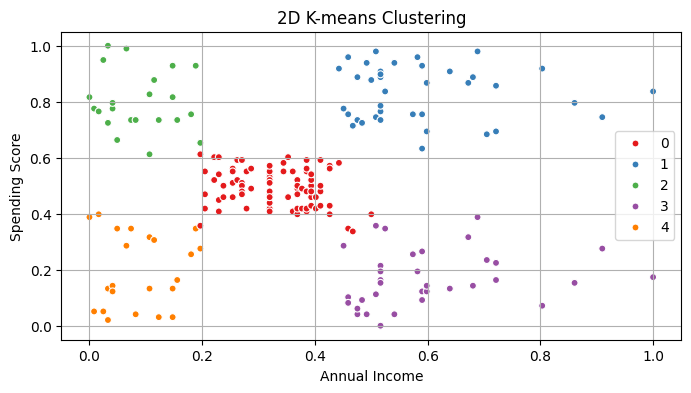

In [21]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data_scaled[:, 0], y=data_scaled[:, 1], hue=labels, palette='Set1', s=100, alpha=1, marker = '.')
plt.title('2D K-means Clustering')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.grid(True)
plt.show()

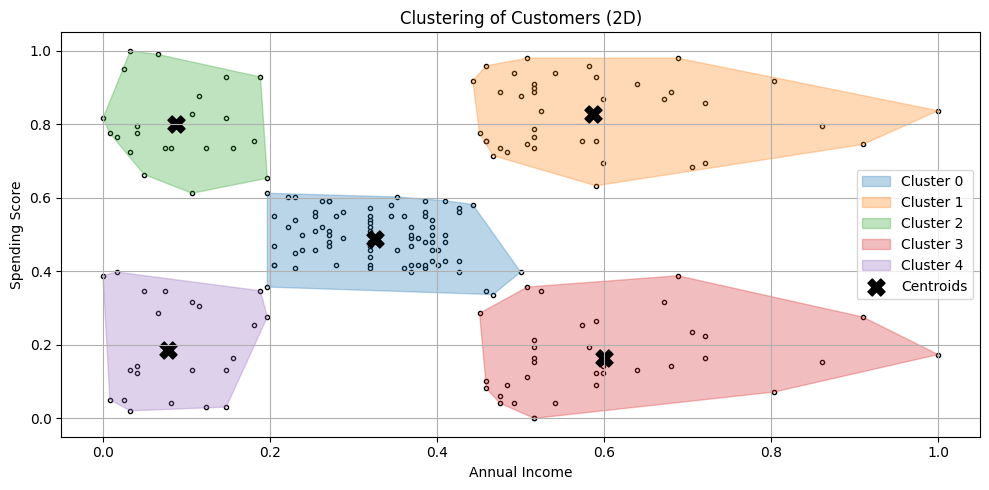

In [22]:
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(10, 5))

# Plot clusters
for i, color in enumerate(cluster_colors):
    cluster_points = data_scaled[labels == i]
    hull = ConvexHull(cluster_points)
    plt.scatter(data_scaled[labels == i, 0], data_scaled[labels == i, 1],
                c='white', marker='.', edgecolors='black')
    plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1],
             c=color, alpha=0.3, label=f'Cluster {i}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', label='Centroids', marker='X', s=150)

plt.legend()
plt.title('Clustering of Customers (2D)')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels

plt.show()